In [1]:
#Projede kulanacağımız kütüphaneleri yüklüyoruz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
#Veri setimizin yolunu verdik
data_dir = pathlib.Path(r"C:\Users\Said Akca\Desktop\kagglecatsanddogs_3367a\PetImages")

In [3]:
#Kedi ve Köpek dosyalarının içindeki dosyaları aldık

dogs = list(data_dir.glob('Dog/*'))

In [4]:
cats = list(data_dir.glob('Cat/*'))

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [6]:

#2 sınıftan toplam veri adedi
image_count

10000

In [7]:
#Verileri labellaştırdık 

pet_images_dict = {
    'cats': list(data_dir.glob('Cat/*')),
    'dogs': list(data_dir.glob('Dog/*')),
}

pet_labels_dict = {
    'cats': 0,
    'dogs': 1,
}

In [8]:
#Resimlerin hepsini aynı boyuta getirdik

IMAGE_WIDTH=150
IMAGE_HEIGHT=150
X, Y = [], []

for pet_name, images in pet_images_dict.items():
    print(pet_name)
    for image in images:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)): 
            continue
            
        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(pet_labels_dict[pet_name])
        else:
            continue

cats
dogs


In [9]:
#Çıktıları numpy array dönüştürdük

X = np.array(X)
Y = np.array(Y)

In [10]:
#Normalizasyon işlemini gerçekleştirdik
X= X/255

In [11]:
#veriler train test val olarak ayırdık
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42)

In [12]:
#Transfer Learning olarak vgg 19 modelini seçtik

vgg19 = tf.keras.applications.VGG19(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = None,
    input_shape = (150,150,3), 
    pooling = None, 
    classes = 1000
)

In [13]:
vgg19.trainable = False

In [30]:
model_vgg = tf.keras.models.Sequential([
    
    vgg19,
    tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),# modifying final layers of VGG-19
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = 'same'),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.PReLU(alpha_initializer='zeros'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [31]:
import tensorflow_addons as tfa

In [32]:
metrics = ['accuracy']

In [33]:
#optimizer ve loss fonksiyonu seçtim
model_vgg.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = metrics)
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         589952    
                                                                 
 p_re_lu_3 (PReLU)           (None, 4, 4, 128)         2048      
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 p_re_lu_4 (PReLU)           (None, 4, 4, 64)          1024      
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [34]:
y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))

In [35]:
Y_val=np.asarray(Y_val).astype('float32').reshape((-1,1))

In [36]:
#Model fit
history_vgg = model_vgg.fit(
    X_train,y_train,
    epochs = 20,
    validation_data = (X_val, Y_val),
    batch_size=32,
    verbose = 1)

Epoch 1/20
174/174 [==============================] - 16s 87ms/step - loss: 0.3894 - accuracy: 0.8227 - val_loss: 0.3076 - val_accuracy: 0.8657
Epoch 2/20
174/174 [==============================] - 15s 84ms/step - loss: 0.2809 - accuracy: 0.8786 - val_loss: 0.2837 - val_accuracy: 0.8786
Epoch 3/20
174/174 [==============================] - 15s 84ms/step - loss: 0.2320 - accuracy: 0.9015 - val_loss: 0.3417 - val_accuracy: 0.8560
Epoch 4/20
174/174 [==============================] - 15s 84ms/step - loss: 0.1885 - accuracy: 0.9238 - val_loss: 0.3435 - val_accuracy: 0.8706
Epoch 5/20
174/174 [==============================] - 15s 85ms/step - loss: 0.1714 - accuracy: 0.9310 - val_loss: 0.2998 - val_accuracy: 0.8862
Epoch 6/20
174/174 [==============================] - 15s 84ms/step - loss: 0.1297 - accuracy: 0.9495 - val_loss: 0.3447 - val_accuracy: 0.8808
Epoch 7/20
174/174 [==============================] - 15s 85ms/step - loss: 0.1142 - accuracy: 0.9572 - val_loss: 0.4029 - val_accuracy:

In [37]:
#Graifk çizimleri
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

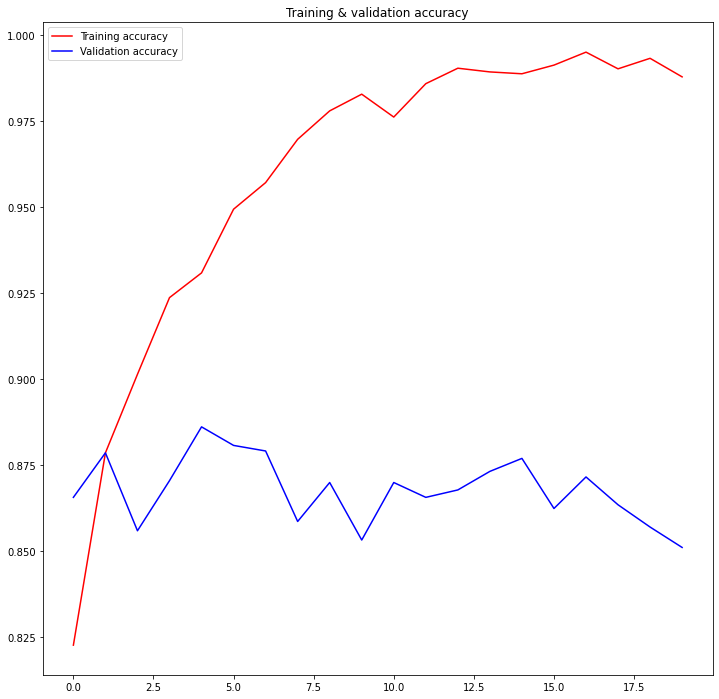

In [38]:
plt.figure(figsize=(12,12))
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training & validation accuracy')
plt.legend()

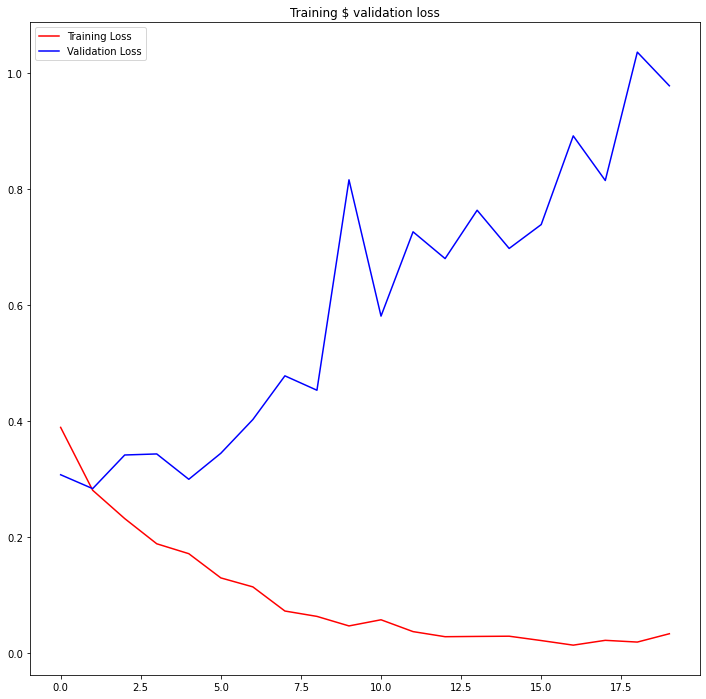

In [39]:
plt.figure(figsize = (12,12))

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training $ validation loss')
plt.legend()

plt.show()

In [40]:

#Modelin test doğruluğu
model_vgg.evaluate(X_test, y_test)

78/78 [==============================] - 5s 63ms/step - loss: 1.1148 - accuracy: 0.8394


[1.114770531654358, 0.8394013047218323]